# Grupo conformado por:
- Dario Herrrera
- Jacqueline Reina
- Cristina Pavón
- Karen Mangui
- Edgar Silva 
- Magdalena Jingo
- Adriana Porras
- Víctor Pilataxi 
- Mónica Moreta
- Miguel Espinoza
- Domenica Gomez

# Predicción de Series Temporales utilizando FbProphet

La predicción de series temporales es de los casos más habituales y aplicables dentro del Machine Learning. Por ejemplo, models de 'forecasting' se pueden encontrar en para la predicción de precios, demanda, temperatura,  tiempo de respuesta, ventas, ritmo cardiaco, producción, etc. 

El gran reto se encuentra en que, a diferencia de algunos otros casos de Machine Learning, la predicción a futuro depende en gran medida, de los datos históricos de la serie. Es decir, por ejemplo si queremos predecir la temperatura media por hora, el dato más relevante que podemos utilizar es la misma serie de temperaturas por hora. A este tipo de modelos se los llama **Auto-regresivos.** 

En la práctica, los modelos auto-regresivos pueden desarrollarse sin ninguna otra variable auxiliar (covariantes), sin embargo, es común añadir regresores externos para complementar el poder predictivo del modelo. 

## Caso de uso: Predicción de la demanda de Bicicletas en una plataforma de BikeSharing en Washington DC. 

Somos Data Scientist en una empresa de Bike Sharing. Básicamente es una aplicación en donde los usuarios pueden registrarse, utilizar bicicletas de nuestra empresa que están localizadas a lo largo de la ciudad, y luego, cuándo llegan a destino, las dejan para que otros usuarios puedan usarlas también. La empresa está en proceso de expansión, por lo que han decidido comprar nuevas bicicletas para colocarlas a lo largo de toda la ciudad. Sin embargo, se ha decidido que se comprarán las bicicletas en función de la cantidad de demanada diaria en el futuro. Por lo que se nos ha pedido que realicemos un modelo de predicción de la demanda. La compra tendrá que hacerse urgentemente, por lo que el reto será predecir la demanda de las siguientes dos semanas. 

- Para ello tenemos datos históricos de demanda y la siguiente información:
    - instant: identificador de la fila.
    - dteday: fecha.
    - hr: hora.
    - weathersit: descripción de la situación climática
    - temp: temperatura en celcius (normalizado con división por 41 (max))
    - atemp: sensación térmica (normalizado, dividido por 50 (max))
    - hum: humedad normalizada. Valores divividos por 100 (max)
    - windspeed: velocidad del viento normalizada
    - casual: conteo de usuarios casuales (no registrados)
    - registered: conteo de usuarios registrados en la app
    - cnt: conteo total usuarios (registrados y casuales). Esta sería la variable objetivo.


Reto: Predecir la demanda de uso para las siguientes dos semanas (14 días)!  



# Importamos paquetes y definimos helpers

Se ha incluído el código base para cargar los datos y transformarlos en formato diario. Además de algunas funciones que nos ayuden a verificar outliers, como también para evaluar el modelo. 

PISTA: Si queremos predecir la cantidad de usuarios, las columnas casual y registered no nos serán útiles ya que contienen información a posteriori. 

In [33]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns



def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true, pred):
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))

## Cargamos los Datos y exploración inicial 

In [34]:
#gdrive location:
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [35]:
df.sample(5)

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1118,1119,2011-02-19,8,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.38,0.3939,0.17,0.5821,9,36,45
7702,7703,2011-11-22,13,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.42,0.4242,1.00,0.0896,4,22,26
2005,2006,2011-03-29,10,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.30,0.2727,0.24,0.2985,13,46,59
2565,2566,2011-04-21,19,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.46,0.4545,0.28,0.2836,52,272,324
14836,14837,2012-09-15,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.60,0.6212,0.43,0.4179,79,263,342


In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB


In [37]:
# Revisamos la cantidad de valores vacíos en las variables
df.isnull().sum()

instant         0
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

In [38]:
#verificamos si existe más de dos valores nulos en una misma fila
# Contamos el número de valores vacíos en cada fila
num_nulos = df.isna().sum(axis=1)
# Verificar si hay dos o más valores vacíos en cada fila
nulos_fila = num_nulos >= 2
df[nulos_fila]

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
9150,9151,2012-01-22,4,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.16,NaN,NaN,0.2836,1,1,2
10126,10127,2012-03-03,0,NaN,0.36,NaN,0.93,0.0896,1,21,22
13683,13684,2012-07-29,8,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.70,0.6515,NaN,NaN,37,90,127


In [39]:
# Revisamos la cantidad de valores únicos en la variable descripción del clima
df['weathersit'].unique()

array(['Clear, Few clouds, Partly cloudy, Partly cloudy',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       nan, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'],
      dtype=object)

In [40]:
w = pd.get_dummies(df["weathersit"])
df = pd.concat([df, w], axis=1)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column                                                                                   Non-Null Count  Dtype         
---  ------                                                                                   --------------  -----         
 0   instant                                                                                  17379 non-null  int64         
 1   dteday                                                                                   17379 non-null  datetime64[ns]
 2   hr                                                                                       17379 non-null  int64         
 3   weathersit                                                                               17279 non-null  object        
 4   temp                                                                                     17280 non-null  float64       
 5   atemp      

In [42]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,"Clear, Few clouds, Partly cloudy, Partly cloudy","Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16,1,0,0,0
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40,1,0,0,0
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32,1,0,0,0
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13,1,0,0,0
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1,1,0,0,0


In [43]:
# localizamos los valores null
null_columns= df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
dtype: int64

In [44]:
df.dropna(inplace=True)

In [45]:
# localizamos los valores null
df.isnull().sum()

instant                                                                                    0
dteday                                                                                     0
hr                                                                                         0
weathersit                                                                                 0
temp                                                                                       0
atemp                                                                                      0
hum                                                                                        0
windspeed                                                                                  0
casual                                                                                     0
registered                                                                                 0
cnt                                                                   

In [46]:
# Cambio los nombres de las columnas dummies
df = df.rename(columns={
                        'Clear, Few clouds, Partly cloudy, Partly cloudy': 'Clear - Pcloudy',
                        'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog':'HrainThM - SnowF',
                        'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds':'LSnowLR - LRainSclouds',
                        'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist':'MistC - Mist' 
                        })

<Axes: >

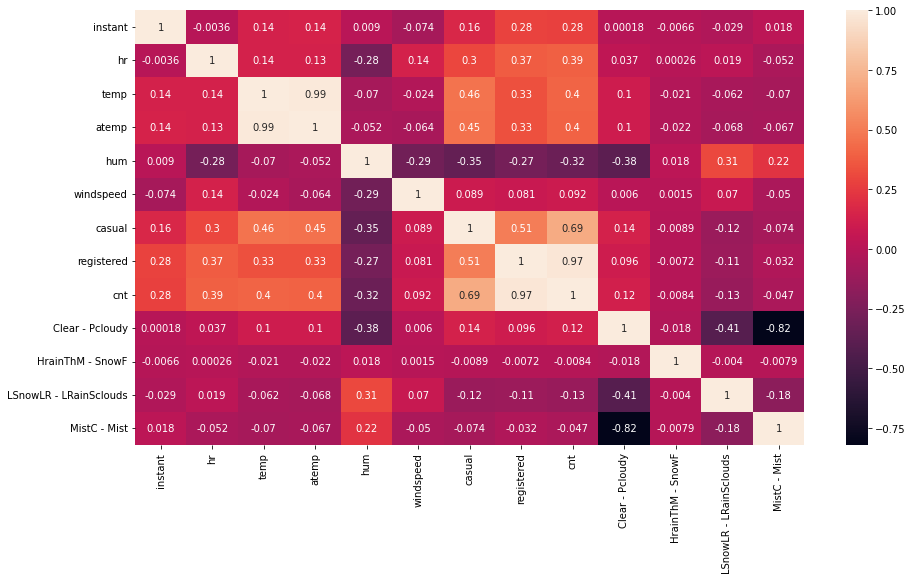

In [47]:
corr = df.corr() 
plt.subplots(figsize=(15,8))
sns.heatmap(corr, annot = True)

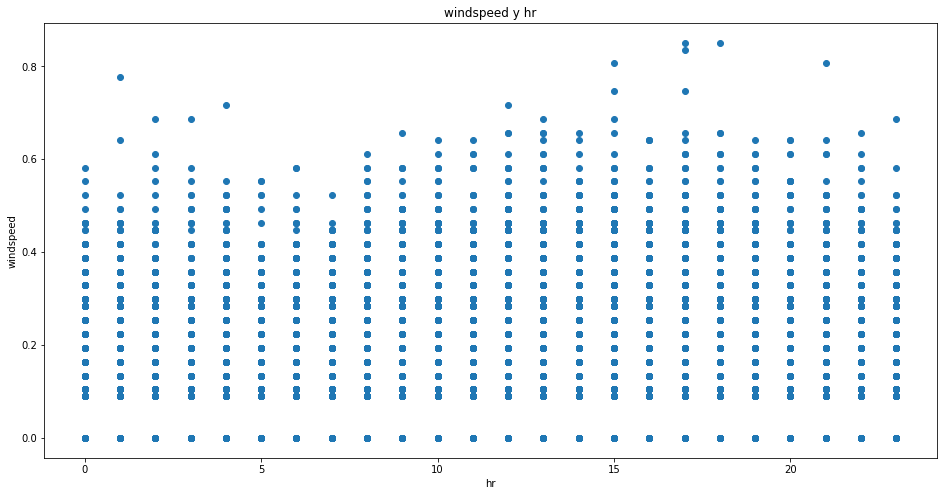

In [48]:
x = 'hr'
y = 'windspeed'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

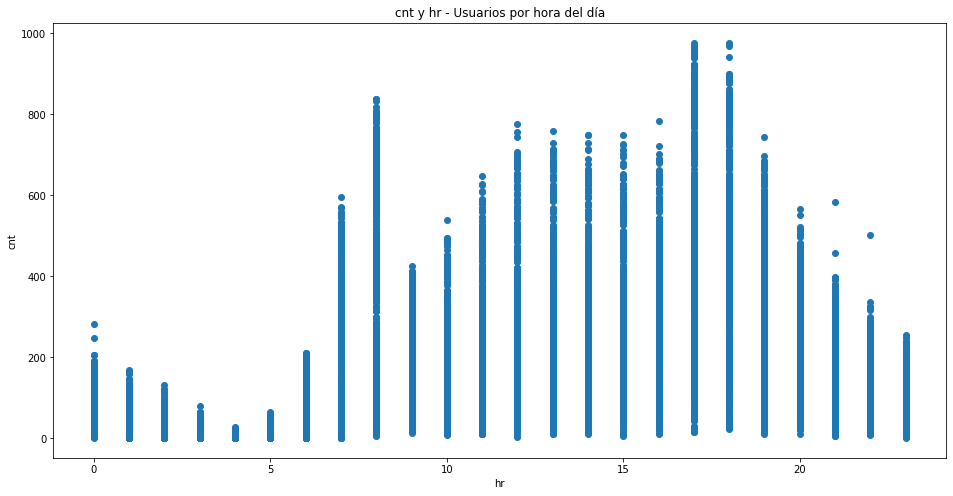

In [49]:
x = 'hr'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x} - Usuarios por hora del día')
plt.show()

In [50]:
df['dteday']=pd.to_datetime(df['dteday'])
df['year']=df['dteday'].dt.year
df['quarter']=df['dteday'].dt.quarter
df['month']=df['dteday'].dt.month
df['day_of_week']=df['dteday'].dt.day_name()
df['hour']=df['dteday'].dt.hour

df['weathersit']=df['weathersit'].map({1:'Clear,Few clouds,Partly cloudy,Partly cloudy',
                                       2:'Mist+Cloudy,Mist+Brokenclouds,Mist+Fewclouds,Mist',
                                       3:'LightSnow,LightRain+Thunderstorm+Scattered clouds,Light Rain+Scatteredclouds',
                                       4:'Heavy Rain+Ice Pallets+Thunderstorm+Mist,Snow+Fog'})

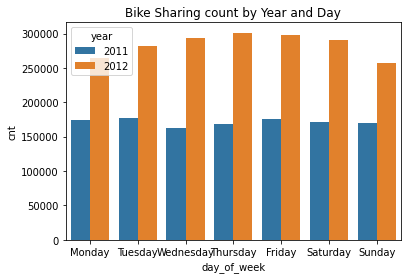

In [51]:
year_day_count=df.groupby(['year','day_of_week'])['cnt'].sum().reset_index()
order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.barplot(data=year_day_count,x='day_of_week',y='cnt',hue='year',order=order)
plt.title('Bike Sharing count by Year and Day')
plt.show()

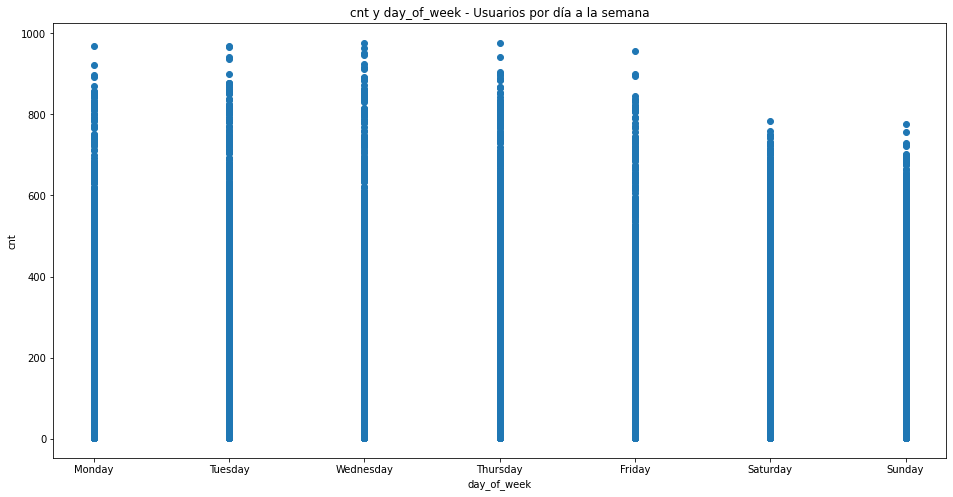

In [52]:
d_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
x = 'day_of_week'
y = 'cnt'

# Crear la columna auxiliar 'd_order' para ordenar los datos
df['d_order'] = df[x].astype('category').cat.reorder_categories(d_order)

# Ordenar los datos por la columna auxiliar 'd_order'
df_sorted = df.sort_values('d_order')

# Crear la gráfica de dispersión con los datos ordenados
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_sorted[x], df_sorted[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x} - Usuarios por día a la semana')
plt.show()

<Axes: >

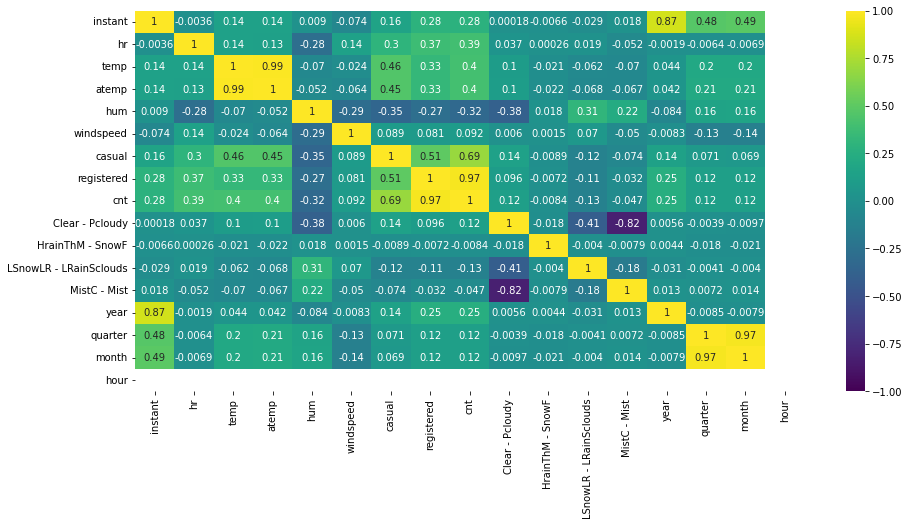

In [53]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

# Formato Datos 

Los datos están por hora, lo que dificulta en gran medida el análisis ya que se agrega muchísimo ruido de horas poco útiles. Para este caso de uso, trabajaremos con predicción de la demanda diaria. 

In [54]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [55]:
df_byday.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1217
3,2011-01-04,1562
4,2011-01-05,1600


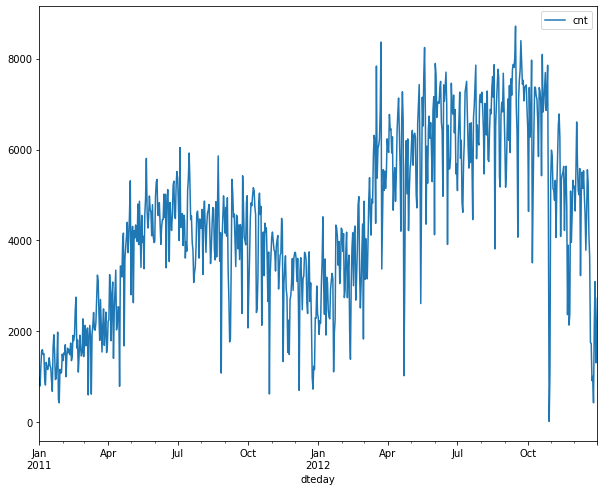

In [56]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

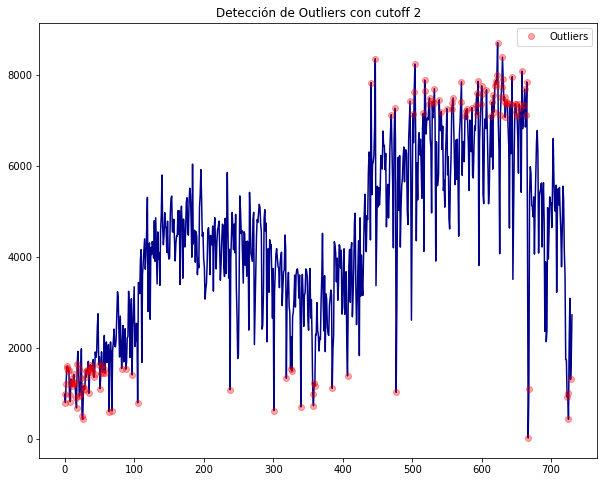

In [57]:
# Outliers
indices2 = plot_outliers_signal(df_byday.cnt.values, threshold = 2)
plt.show()

In [58]:
df_byday.iloc[indices2]

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1217
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
668,2012-10-30,1096
723,2012-12-24,920
724,2012-12-25,1013
725,2012-12-26,432


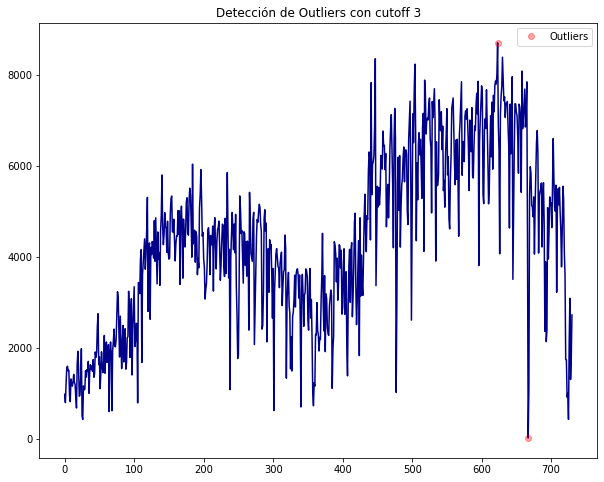

In [59]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)
plt.show()

In [60]:
df_byday.iloc[indices]

,dteday,cnt
623,2012-09-15,8714
667,2012-10-29,22


[Text(0.5, 0, 'mes'),
 Text(0, 0.5, 'Usuarios'),
 Text(0.5, 1.0, 'Box Plot - Usuarios por mes')]

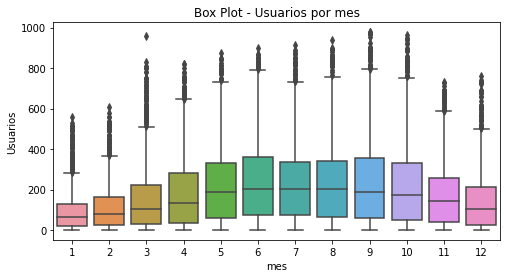

In [61]:
import seaborn as sn

fig, axes = plt.subplots()
fig.set_size_inches(8, 4)

sn.boxplot(data=df,y="cnt",x="month",orient="v",ax=axes)

axes.set(xlabel='mes', ylabel='Usuarios',title="Box Plot - Usuarios por mes")

[Text(0.5, 0, 'hora'),
 Text(0, 0.5, 'Usuarios'),
 Text(0.5, 1.0, 'Box Plot - Usuarios por hora')]

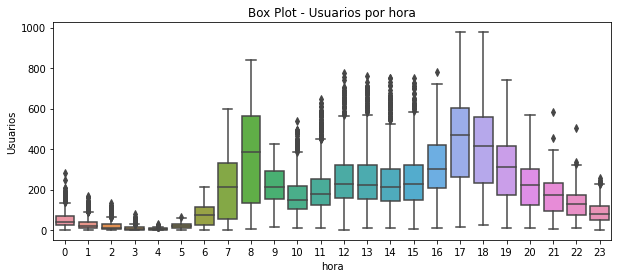

In [62]:
import seaborn as sn

fig, axes = plt.subplots()
fig.set_size_inches(10, 4)

sn.boxplot(data=df,y="cnt",x="hr",orient="v",ax=axes)

axes.set(xlabel='hora', ylabel='Usuarios',title="Box Plot - Usuarios por hora")

Agregamos todas las variables que nos eran útiles. Sin embargo, no todas las podemos tratar de la misma forma

In [84]:
# Eliminamos los outliers con 3 desviaciones estandard
dfo = df[np.abs(df["cnt"]-df["cnt"].mean())<=(3*df["cnt"].std())] 

# Creamos la variable con el contador total por día
dfo_byday = dfo.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [85]:
print ("Df con Ouliers: ",df.shape)
print ("Df sin Ouliers: ",dfo.shape)

Df con Ouliers:  (16883, 21)
Df sin Ouliers:  (16645, 21)


# Modelo de Machine Learning

In [86]:
# Resolución Modelo
dfo.drop(['casual','registered'],axis=1,inplace=True)

<ipython-input-86-66644c298313>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo.drop(['casual','registered'],axis=1,inplace=True)


In [87]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16645 entries, 0 to 17378
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   instant                 16645 non-null  int64         
 1   dteday                  16645 non-null  datetime64[ns]
 2   hr                      16645 non-null  int64         
 3   weathersit              0 non-null      object        
 4   temp                    16645 non-null  float64       
 5   atemp                   16645 non-null  float64       
 6   hum                     16645 non-null  float64       
 7   windspeed               16645 non-null  float64       
 8   cnt                     16645 non-null  int64         
 9   Clear - Pcloudy         16645 non-null  uint8         
 10  HrainThM - SnowF        16645 non-null  uint8         
 11  LSnowLR - LRainSclouds  16645 non-null  uint8         
 12  MistC - Mist            16645 non-null  uint8 

In [88]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for c in dfo.columns:
    if dfo[c].dtype == 'object':
        dfo[c] = le.fit_transform(dfo[c])

<ipython-input-88-88f9a0a486ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo[c] = le.fit_transform(dfo[c])
<ipython-input-88-88f9a0a486ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfo[c] = le.fit_transform(dfo[c])


In [68]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16645 entries, 0 to 17378
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   instant                 16645 non-null  int64         
 1   dteday                  16645 non-null  datetime64[ns]
 2   hr                      16645 non-null  int64         
 3   weathersit              16645 non-null  int64         
 4   temp                    16645 non-null  float64       
 5   atemp                   16645 non-null  float64       
 6   hum                     16645 non-null  float64       
 7   windspeed               16645 non-null  float64       
 8   cnt                     16645 non-null  int64         
 9   Clear - Pcloudy         16645 non-null  uint8         
 10  HrainThM - SnowF        16645 non-null  uint8         
 11  LSnowLR - LRainSclouds  16645 non-null  uint8         
 12  MistC - Mist            16645 non-null  uint8 

In [91]:
X = dfo.drop(['cnt','d_order','dteday'],axis=1)
y = dfo['cnt']

In [92]:
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((13316, 16), (13316,), (3329, 16), (3329,))

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [72]:
# Creamos una avariable de Regresion XGBRegression con parámetros default
xgb_reg = XGBRegressor(n_jobs = -1) # -1 para usar el número máximo de núcleos disponibles en la máquina
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [73]:
# Ajustando el modelo XGBRegression con el set de entrenamiento sin outliers
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [74]:
# Predicción con el set de validación sin outliers
y_pred_test = xgb_reg.predict(X_test)
r2score = round(r2_score(y_pred_test,y_test),2)
# Predicción con el set de validación
print("R2 Score on Test Data is : ",r2score)

R2 Score on Test Data is :  0.94


In [75]:
# Calculando el Mean Sqaured Error & Root Mean Squared Error sin outliers
mse = mean_squared_error(y_test, y_pred_test)
rmse = round(math.sqrt(mse),2)
print(rmse)

39.53


In [ ]:
# Entrenando el modelo con RandomizedSearchCV para hyperparameter tuning
params = {
        'n_estimators' : [100, 200, 500, 750], # número de árboles 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
param_comb = 100

random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

# Fitting on the train set
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=-1,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 5],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 10, 12],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 750],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=3)

In [ ]:
# Printing the best score that we can get using the parameters
print('We can get score of :',random_search.best_score_,' using',random_search.best_params_)

We can get score of : 0.9428429758103827  using {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 1.0}


In [76]:
# Creating XGBRegression model with the select hyperparameters
xgb_reg_hpt = XGBRegressor(subsample=0.6, n_estimators=500, min_child_weight=7,max_depth=12,
                               learning_rate=0.02, gamma=5, colsample_bytree=1, n_jobs = -1)
xgb_reg_hpt.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 5,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [77]:
# Fitting the model on the train set
xgb_reg_hpt.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
# Predicting on the test set
y_pred_test_hpt = xgb_reg_hpt.predict(X_test)

# Calculating R2 score on test set
r2score = round(r2_score(y_pred_test_hpt,y_test),2)*100

# Printing the R2 score on test dataset
print("R2 score on Test Data is : ",r2score)

R2 score on Test Data is :  95.0


In [ ]:
# Calculating Mean Sqaured Error & Root Mean Squared Error of the test set
mse = mean_squared_error(y_test, y_pred_test_hpt)
rmse = round(math.sqrt(mse),2)
print(rmse)

36.45


In [94]:
#seleccionamos campo fechas y variable objetivo
dataf=dfo[["dteday","cnt"]]
dataf.head(3) #Se muestra 3 lineas de los datos con marca

,dteday,cnt
0,2011-01-01,16
1,2011-01-01,40
2,2011-01-01,32


In [95]:
#renombramos las columnas 
dataf.rename(columns={'dteday':'ds',
                        'cnt':'y'},inplace=True)

<ipython-input-95-8685cf613495>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf.rename(columns={'dteday':'ds',


In [80]:
print(dataf)

              ds    y
0     2011-01-01   16
1     2011-01-01   40
2     2011-01-01   32
3     2011-01-01   13
4     2011-01-01    1
...          ...  ...
17374 2012-12-31  119
17375 2012-12-31   89
17376 2012-12-31   90
17377 2012-12-31   61
17378 2012-12-31   49

[16645 rows x 2 columns]


In [ ]:
from prophet import Prophet
m = Prophet()
m.fit(dataf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo36emutd/icg9lovr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo36emutd/vdp_mx3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87671', 'data', 'file=/tmp/tmpo36emutd/icg9lovr.json', 'init=/tmp/tmpo36emutd/vdp_mx3n.json', 'output', 'file=/tmp/tmpo36emutd/prophet_modelesqa0uz4/prophet_model-20230328054232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Iniciamos un dataset que tendrá nuestras predicciones a futuro
future=m.make_future_dataframe(periods=15)
future.tail()

,ds
741,2013-01-11
742,2013-01-12
743,2013-01-13
744,2013-01-14
745,2013-01-15


In [ ]:
# Realizamos el forecast
forecast=m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
741,2013-01-11,188.001085,-27.486508,376.154601
742,2013-01-12,192.056322,1.463793,385.356454
743,2013-01-13,183.371805,-11.846055,375.148834
744,2013-01-14,183.753245,-18.846052,378.337810
745,2013-01-15,191.022362,-9.319195,402.368136


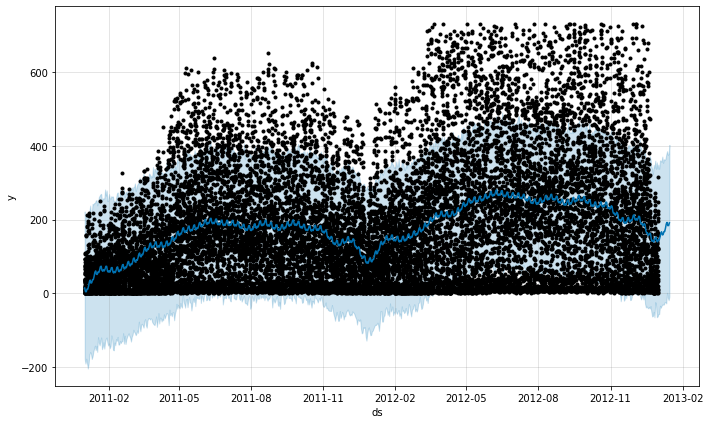

In [ ]:
# Los puntos negros son los reales y linea azul la predicción
f1=m.plot(forecast)

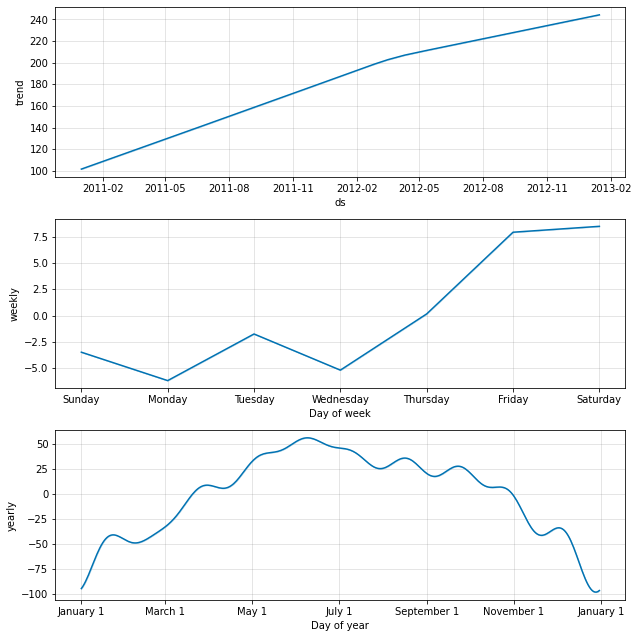

In [156]:
# Ploteamos componentes como Trend y Seasonality
f2=m.plot_components(forecast)

# Evaluación Modelo

In [165]:
# Calculating R2 score
y_train_pred = xgb_reg_hpt.predict(X_train)
y_test_pred = xgb_reg_hpt.predict(X_test)

r2_train_lr = r2_score(y_train, y_train_pred)
print("R2 score on Training data : ",round(r2_train_lr,2)*100)

r2_test_lr = r2_score(y_test, y_test_pred)
print("R2 score on Test data : ",round(r2_test_lr,2)*100)

R2 score on Training data :  99.0
R2 score on Test data :  95.0


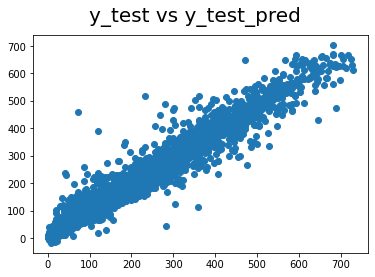

In [168]:
# Plotting a scatter plot of the actual and predicted values of the test set
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('y_test vs y_test_pred',fontsize=20)
plt.scatter(y_test,y_test_pred)
plt.show()

In [160]:
import plotly 

from prophet.plot import plot_plotly

plot_plotly(m, forecast)